# AuralSent: Harmonizing Text and Sound for Sentiment Analysis

In [1]:
#!pip install SpeechRecognition
#!pip install librosa

### Data:

https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/datae

In [2]:
import warnings
warnings.filterwarnings ('ignore')

# Import necessary libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# Set style for plotting
plt.style.use('seaborn')
sns.set_style('darkgrid')



2024-03-22 14:14:38.765189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


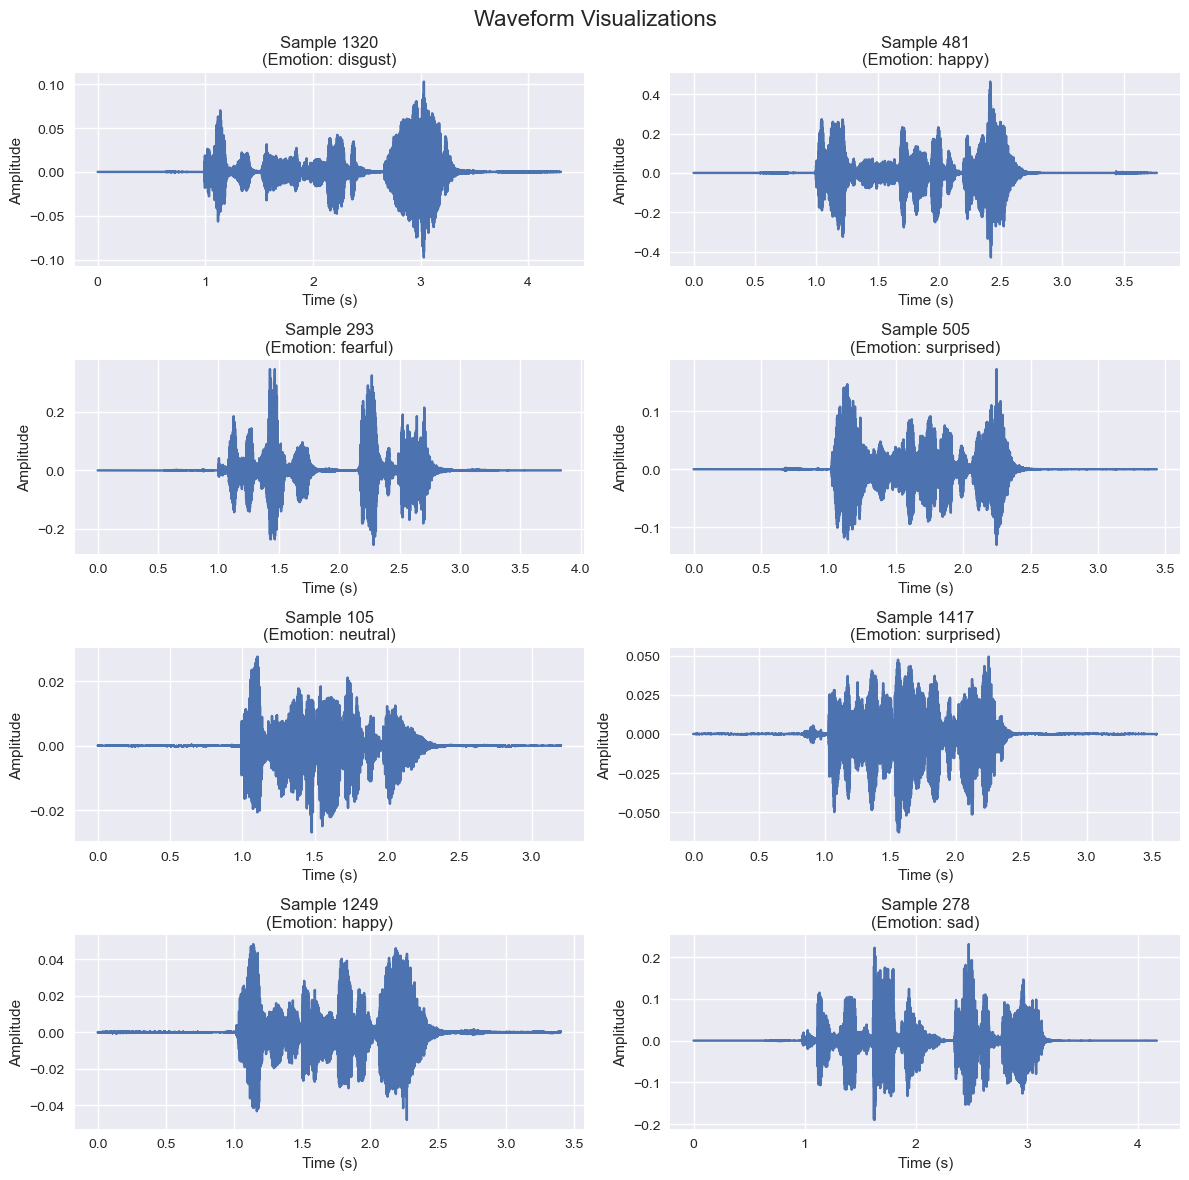

In [3]:
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

speech_data = []  # This will contain file paths
speech_labels = []  # This will contain corresponding labels
dataset_path = 'archive/'

actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
for actor_dir in actor_dirs:
    actor_path = os.path.join(dataset_path, actor_dir)
    filenames = os.listdir(actor_path)
    for filename in filenames:
        speech_data.append(os.path.join(actor_path, filename))
        # Assuming label is the third item in filename split by '-'
        speech_labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

#Random Sample Selection: Choose random samples from your dataset for visualization. 
sample_indices = np.random.choice(len(speech_data), size=8, replace=False)



num_rows = 4
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

fig.suptitle("Waveform Visualizations", fontsize=16)

for i, index in enumerate(sample_indices):
    row = i // num_cols
    col = i % num_cols

    audio_data, sr = librosa.load(speech_data[index])
    label_index = speech_labels[index]
    emotion = emotion_labels[label_index]

    duration = len(audio_data) / sr
    time = np.linspace(0, duration, num=len(audio_data))

    ax = axes[row, col]
    ax.plot(time, audio_data)
    ax.set_title(f"Sample {index+1}\n(Emotion: {emotion})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


## load data

In [9]:
def extract_features_and_labels(dataset_path):
    features, labels = [], []
    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Actors Progress"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            # Extract MFCCs
            y, sr = librosa.load(file_path, sr=None)  # 'sr=None' for the file's original sample rate
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            features.append(mfccs)
            # Extract emotion (3rd item in the filename split by '-')
            labels.append(int(filename.split('-')[2]) - 1)  # Subtract 1 to make labels start from 0
    return np.array(features), to_categorical(np.array(labels))


dataset_path = 'archive/'
features, labels = extract_features_and_labels(dataset_path)


Actors Progress: 100%|██████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


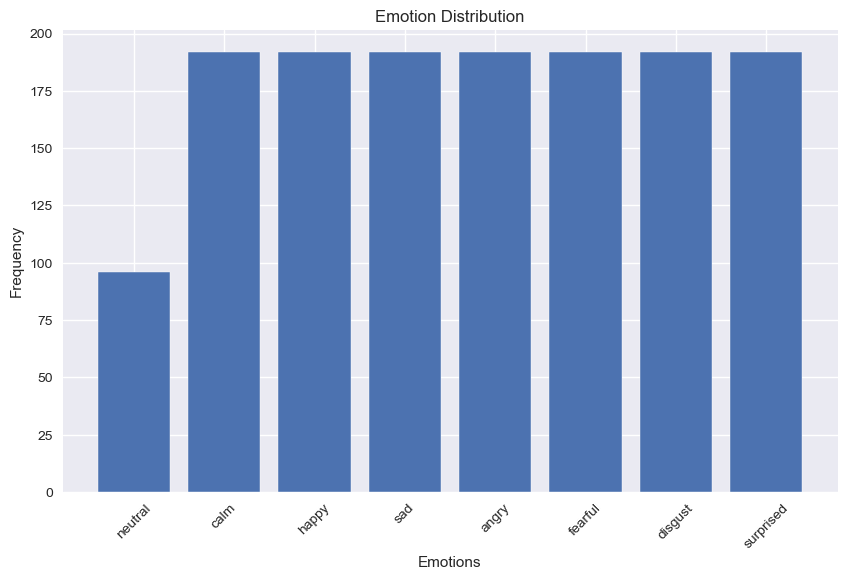

In [5]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each emotion
emotion_counts = {label: speech_labels.count(label) for label in set(speech_labels)}

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(emotion_labels)), labels=emotion_labels, rotation=45)
plt.show()


Analyzing audio lengths: 100%|████████████| 1440/1440 [00:00<00:00, 2540.96it/s]


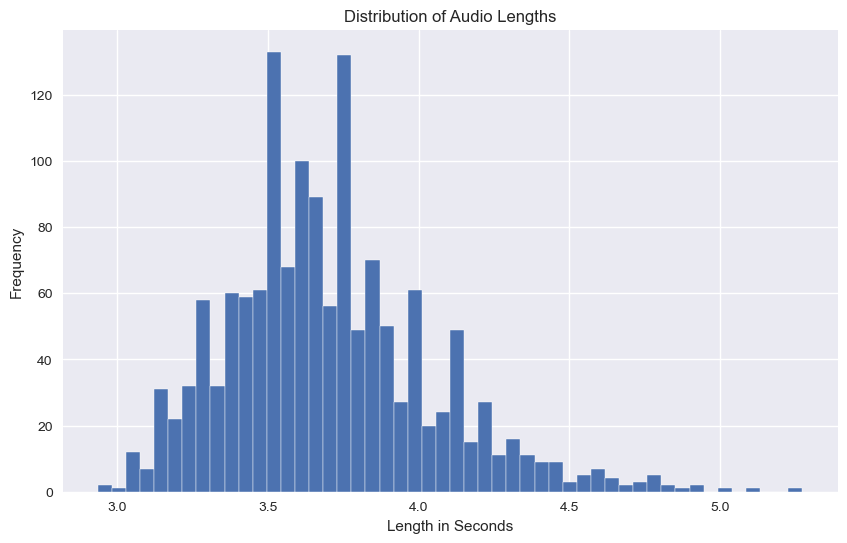

In [6]:
audio_lengths = []

for file_path in tqdm(speech_data, desc="Analyzing audio lengths"):
    y, sr = librosa.load(file_path, sr=None)
    audio_lengths.append(len(y) / sr)  # Length in seconds

# Plot the distribution of audio lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=50)
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length in Seconds')
plt.ylabel('Frequency')
plt.show()

In [7]:
corrupted_files = []

for file_path in tqdm(speech_data, desc="Checking for corrupted files"):
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        corrupted_files.append(file_path)

if corrupted_files:
    print(f"Found {len(corrupted_files)} corrupted files.")
else:
    print("No corrupted files found.")

Checking for corrupted files: 100%|███████| 1440/1440 [00:00<00:00, 2789.18it/s]

No corrupted files found.


### Feature Augmentation: 
extracted pitch, magnitude, and tempo, consider augmenting your feature set with these for all files in your dataset. These features can be concatenated with the MFCCs to form a richer feature set.

In [8]:
def extract_additional_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return np.mean(pitch), np.mean(mag), tempo

# Example for one file
pitch, mag, tempo = extract_additional_features(speech_data[0])
print(f"Pitch: {pitch}, Magnitude: {mag}, Tempo: {tempo}")

def augment_features_with_pitch_tempo(features, speech_data):
    augmented_features = []
    for i, file_path in enumerate(tqdm(speech_data, desc="Augmenting Features")):
        pitch, mag, tempo = extract_additional_features(file_path)
        augmented_feature = np.append(features[i], [pitch, mag, tempo])
        augmented_features.append(augmented_feature)
    return np.array(augmented_features)

augmented_features = augment_features_with_pitch_tempo(features, speech_data)

Pitch: 25.24271583557129, Magnitude: 0.014032362028956413, Tempo: 200.89285714285714


Augmenting Features:  46%|████████▋          | 662/1440 [01:01<01:15, 10.31it/s]

## prep data

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)  # Use labels directly

# Further split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler().fit(X_train)  # Fit on the training data
X_train = scaler.transform(X_train)  # Transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data

# Reshape features for Conv1D input
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (864, 40, 1)
y_train shape: (864, 8)
X_val shape: (288, 40, 1)
y_val shape: (288, 8)
X_test shape: (288, 40, 1)
y_test shape: (288, 8)
